# Random Forest Classifier

```{tip}
It is recommended to use google colaboratory to run this notebook
```

Random forest classifier is one of the most widely used ensemble method. This algorithm trains a number of decision trees on various subsamples of data and then use averaging method to improve model accuracy and control over-fitting. In other words, this method uses bootstrapping with averaging to improve the model. Also, during the splitting each node in the trees either all the features are used or subset of features are used, depending on the parameter used for training. Th above mentioned methods are used to control the variance. The scikit-learn classifier averages the probabilitic prediction instead of making all the trees to vote for the target class.

In [ ]:
# Extra libraries required

# Install ray tune
! pip install tune-sklearn ray[tune]

# Install shap
! pip install shap

In [2]:
# Import necessary packages
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import plotly.express as px
import plotly.io as pio

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
# Set default plotly renderer
pio.renderers.default = "notebook_connected" # Use "colab" when running in google colaboratory

In [4]:
# Load data into dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uci/ospi/datasets/preprocessed_osi.csv')

## Preprocessing

These preprocessing steps are the same as used for the previously trained models.

In [5]:
y = df['Revenue']
X = df.drop('Revenue', axis=1)

In [6]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Even random forest cannot perform better with class imbalance, hence it is necessary to oversample the minority target class.

In [7]:
# Oversample the minority class in the target variable
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Model Training

In [8]:
# Declare estimator
estimator = RandomForestClassifier(warm_start=True, class_weight="balanced")

# Declare cross validation method
cv = StratifiedKFold()

# Declare paramter grid
param_grid = dict(
    n_estimators = [50, 100, 200, 400],
    max_depth = [10, 20, 40],
    min_samples_split = [2, 5, 10],
    max_features = ["auto", "log2", None],
    bootstrap = [False, True],
)

In [ ]:
# Import grid search from tune sklearn
from tune_sklearn import TuneGridSearchCV

# Train the model
ran_for_clf = TuneGridSearchCV(estimator=estimator, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1, use_gpu=True, verbose=2)
ran_for_clf.fit(X_train, y_train)

In [10]:
ran_for_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=True)

In [8]:
# # Save and load the model if required
import joblib
# joblib.dump(ran_for_clf.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/ran_for.pkl')
ran_for_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/ran_for.pkl')

In [9]:
# Get predictions from the model
y_pred = ran_for_clf.predict(X_test)

## Model Evaluation

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2594
        True       0.65      0.70      0.67       489

    accuracy                           0.89      3083
   macro avg       0.80      0.81      0.80      3083
weighted avg       0.90      0.89      0.89      3083



# Model Interpretation

Like other tree models, random forest can also gives us the importance of features that are use by the model for prediction.

In [11]:
# Create a feature importance dataframe
feat_imp_data = zip(list(df.drop('Revenue', axis=1).columns), ran_for_clf.feature_importances_)
feat_imp_df = pd.DataFrame(columns=['column', 'feature_importance'], data=feat_imp_data)

In [12]:
# Sort feature importance
feat_imp_df.sort_values('feature_importance', ascending=False, inplace=True)

In [24]:
fig = px.bar(feat_imp_df[:20], x='feature_importance', y='column', orientation='h')
fig.show()

As is the case with other models, random forest also considers page values to be the most important parameter by a huge margin. Next in the line is the month of november followed by the features related to product related pages Exit rates and bounce rates also made to the top important features.

In [14]:
# Import shap
import shap

In [18]:
# Comput shap values
explainer = shap.explainers.Tree(ran_for_clf, X_train, feature_names=df.drop('Revenue', axis=1).columns)
shap_values = explainer.shap_values(X_test, check_additivity=False)

100%|===================| 6142/6166 [04:04<00:00]       

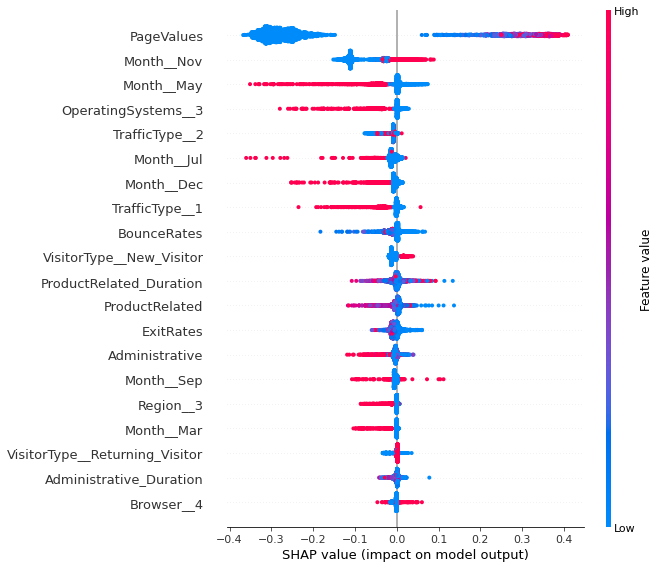

In [22]:
shap.summary_plot(shap_values[1], X_test, df.drop('Revenue', axis=1).columns)

Random forest is much more clear about the importance of feature values. As usual, higher the page values higher the chance that a visitor will transact. People are more likely to transact in the month of Novemer and less likely to transact in the month of May. Surprisingly, the features related to product related pages are quite unimportant and the model is finding it difficult to use them appropriately. People using operating system 3 and traffic type 1 are less likely to transact. It can also be observed that model is finidng it difficult to use exit rates and boounce rate features.